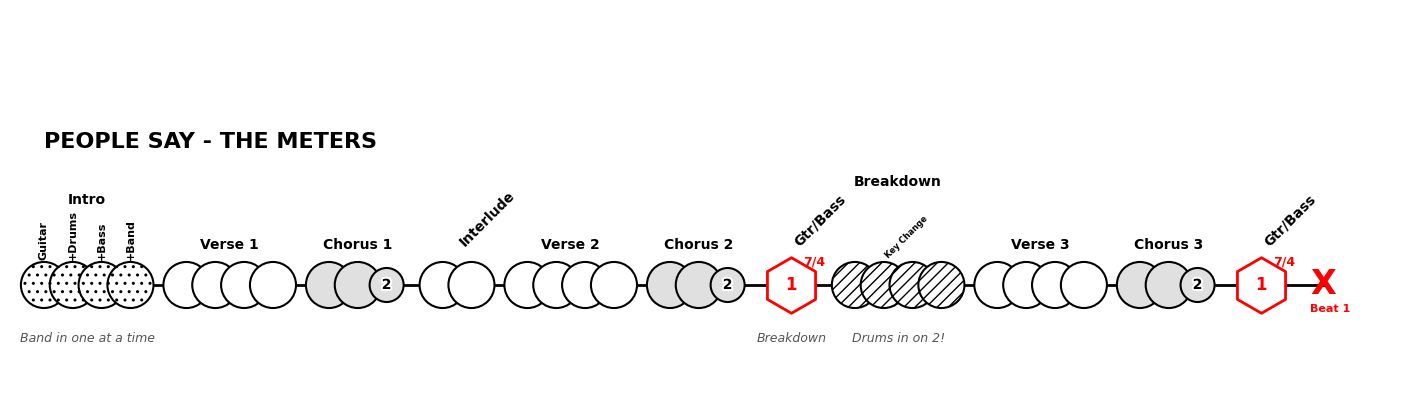

In [115]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import itertools

def visualize_song(title, structure, style='compact'):
    """
    V19: Reverted note staggering (clean baseline) & Fixed Solo Box clearance.
    """
    
    # --- 1. DYNAMIC STYLE ENGINE ---
    hatch_pool = itertools.cycle(['', '...', '///', '|||', 'xxx', '+++', 'OO', '**'])
    face_pool = itertools.cycle(['white', '#f0f0f0', 'white', '#e0e0e0'])
    
    section_styles = {}
    section_styles['Intro'] = {'face': 'white', 'edge': 'black', 'hatch': '..', 'lw': 1.5}
    section_styles['Verse'] = {'face': 'white', 'edge': 'black', 'hatch': '', 'lw': 1.5}
    section_styles['Chorus'] = {'face': '#e0e0e0', 'edge': 'black', 'hatch': '', 'lw': 1.5}
    
    def get_style(section):
        name = section.get('name', 'Section')
        base_name = name.split()[0] 
        if base_name not in section_styles:
            section_styles[base_name] = {
                'face': next(face_pool),
                'edge': 'black',
                'hatch': next(hatch_pool),
                'lw': 1.5
            }
        return section_styles[base_name]

    # --- 2. LAYOUT CALCULATION ---
    layout_items = []
    current_x = 0
    bars_per_bead = 4
    base_spacing = 0.8     
    bead_spacing = 0.85    
    
    hazard_face = 'white'
    hazard_edge = 'red'
    hazard_text = 'red'
    text_color = 'black'
    bg_color = 'white'
    
    for section in structure:
        name = section.get('name', 'Section')
        bars = section.get('bars', 4)
        
        is_hazard = (bars < 4) and not section.get('force_beads', False)
        
        if is_hazard:
            num_beads = 1
            visual_width = 1.3 
        else:
            num_full = bars // bars_per_bead
            remainder = bars % bars_per_bead
            num_beads = num_full + (1 if remainder > 0 else 0)
            visual_width = (num_beads * bead_spacing)

        label = section.get('solo') if section.get('solo') else name
        should_rotate = (len(label) > 6 and visual_width < 2.5) or (len(label) > 10)
        
        # Calculate Padding
        padding = base_spacing
        if should_rotate:
            text_len = len(label) * 0.15
            overhang = max(0, text_len - visual_width) * 0.8 
            padding += overhang
            
        if section.get('ending'):
            padding += 1.5 

        layout_items.append({
            'x': current_x,
            'width': visual_width, 
            'data': section,
            'is_hazard': is_hazard,
            'num_beads': num_beads,
            'should_rotate': should_rotate
        })
        
        current_x += visual_width + padding

    # --- 3. DRAWING ---
    fig, ax = plt.subplots(figsize=(max(12, current_x/2.2), 5), facecolor=bg_color)
    ax.set_facecolor(bg_color)
    ax.axis('off')
    y_pos = 0.5
    
    # CALCULATE END OF TIMELINE
    last_item = layout_items[-1]
    last_section = last_item['data']
    end_x = last_item['x'] + last_item['width'] - (bead_spacing if not last_item['is_hazard'] else 0)
    
    if last_section.get('ending'):
        end_x = last_item['x'] + last_item['width'] + 0.8
        
    start_x = layout_items[0]['x']
    ax.plot([start_x, end_x], [y_pos, y_pos], color='black', linewidth=2, zorder=1)

    for item in layout_items:
        section = item['data']
        start_draw_x = item['x']
        is_hazard = item['is_hazard']
        should_rotate = item['should_rotate']
        
        style_def = get_style(section)
        
        # --- SOLO BOX (Adjusted Height) ---
        if section.get('solo'):
            box_margin = 0.5
            box_width = item['width'] + (box_margin * 1.5) - (bead_spacing if not is_hazard else 0)
            if not is_hazard: box_width += 0.1
            
            box_x = start_draw_x - box_margin
            
            # Height = 1.3 (slightly smaller than 1.4 to clear bottom text)
            box_h = 1.3
            box_y = y_pos - 0.65 # Shifted up slightly
            
            bbox = patches.FancyBboxPatch(
                (box_x, box_y), box_width, box_h,
                boxstyle="round,pad=0.1,rounding_size=0.2",
                linewidth=1.5, edgecolor='black', facecolor='none', linestyle='--', zorder=2
            )
            ax.add_patch(bbox)
            
        # --- DRAW BEADS ---
        if is_hazard:
            draw_center = start_draw_x + (item['width'] / 2) - (bead_spacing/2)
            center_x = draw_center 
            
            ax.scatter(draw_center, y_pos, s=1600, 
                       facecolors=hazard_face, edgecolors=hazard_edge, 
                       marker='h', linewidth=2, zorder=3)
            ax.text(draw_center, y_pos, str(section['bars']), 
                    color=hazard_text, fontsize=12, fontweight='bold', 
                    ha='center', va='center', zorder=4)
            if section.get('meter'):
                ax.text(draw_center + 0.35, y_pos + 0.35, section['meter'], 
                        color='red', fontsize=9, fontweight='bold', zorder=5)
            
        else:
            bars = section['bars']
            num_full = bars // bars_per_bead
            remainder = bars % bars_per_bead
            curr_bead_x = start_draw_x
            
            bead_labels = section.get('bead_labels')
            def get_bead_labels(idx):
                if not bead_labels: return []
                val = None
                if isinstance(bead_labels, dict): val = bead_labels.get(idx)
                elif isinstance(bead_labels, list) and idx < len(bead_labels): val = bead_labels[idx]
                if val is None: return []
                return val if isinstance(val, list) else [val]

            for i in range(num_full + (1 if remainder > 0 else 0)):
                is_remainder = (i == num_full and remainder > 0)
                force_text = section.get('force_beads', False)
                size = 600 if (is_remainder or force_text) else 1100
                
                if is_remainder: text_inside = str(remainder)
                elif force_text: text_inside = str(bars) if num_full == 0 else '' 
                else: text_inside = ''
                
                ax.scatter(curr_bead_x, y_pos, s=size, 
                           facecolors=style_def['face'], edgecolors=style_def['edge'], 
                           marker='o', hatch=style_def['hatch'] if style=='compact' else '', 
                           linewidth=style_def['lw'], zorder=3)
                
                if text_inside:
                    txt = ax.text(curr_bead_x, y_pos, text_inside, color='black', 
                                  fontsize=10, fontweight='bold', ha='center', va='center', zorder=4)
                    txt.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])
                
                # Stacked Labels
                labels = get_bead_labels(i)
                stack_y = y_pos + 0.45
                for lbl in labels: 
                    is_long = len(str(lbl)) > 6
                    font_size = 6 if is_long else 8
                    rot_angle = 45 if is_long else 90
                    y_step = 0.25 if is_long else 0.4
                    ax.text(curr_bead_x, stack_y, lbl, 
                            color=text_color, fontsize=font_size, fontweight='bold', 
                            ha='left' if is_long else 'center', va='bottom', rotation=rot_angle)
                    stack_y += y_step

                curr_bead_x += bead_spacing

            total_bead_width = ((item['num_beads']-1) * bead_spacing)
            center_x = start_draw_x + (total_bead_width / 2)

        # --- SECTION TITLE ---
        label = section.get('solo') if section.get('solo') else section['name']
        label_y_offset = 0.65
        
        if section.get('bead_labels'):
             max_stack_height = 0
             lbls = section['bead_labels']
             values_to_check = lbls.values() if isinstance(lbls, dict) else lbls
             for v in values_to_check:
                 v_list = v if isinstance(v, list) else [v]
                 height = 0
                 for item in v_list:
                     height += 0.4 + (len(str(item))*0.08)
                 max_stack_height = max(max_stack_height, height)
             label_y_offset = 0.6 + max_stack_height

        if section.get('solo'): label_y_offset += 0.25 

        if should_rotate:
            ax.text(center_x, y_pos + label_y_offset, label, 
                    color=text_color, fontsize=10, fontweight='bold', 
                    rotation=45, ha='left', va='bottom')
        else:
             ax.text(center_x, y_pos + label_y_offset, label, 
                     color=text_color, fontsize=10, fontweight='bold', ha='center')

        # --- BOTTOM NOTE (Single Baseline) ---
        if section.get('note'):
             # Fixed Y position for consistency
             ax.text(center_x, y_pos - 0.85, section['note'], 
                     color='#555555' if style=='compact' else '#cccccc', 
                     fontsize=9, style='italic',
                     rotation=0, ha='center', va='top')

        # --- ENDING SYMBOLS ---
        if section.get('ending'):
            end_icon_x = start_draw_x + item['width'] - (bead_spacing/2) + 0.8
            if section['ending'] == 'stop':
                ax.text(end_icon_x, y_pos, 'X', color='red', fontsize=24, fontweight='bold', 
                        ha='left', va='center', zorder=20)
            elif section['ending'] == 'sustain':
                arc = patches.Arc((end_icon_x, y_pos + 0.2), 0.4, 0.3, theta1=0, theta2=180, 
                                  color='black', lw=2, zorder=20)
                ax.add_patch(arc)
                ax.scatter(end_icon_x, y_pos + 0.2, s=50, color='black', zorder=20) 
            if section.get('ending_beat'):
                 ax.text(end_icon_x, y_pos - 0.5, section['ending_beat'], 
                         color='red', fontsize=8, fontweight='bold', zorder=20)

    ax.text(start_x, y_pos + 2.5, title.upper(), color=text_color, fontsize=16, fontweight='bold')
    ax.set_ylim(-1.5, 5.5) 
    ax.set_xlim(start_x - 1, end_x + 2)
    plt.savefig(f"{title}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
# --- USE CASE: "People Say" (The Meters) ---
people_say_data = [
    {'name': 'Intro', 'bars': 16, 'bead_labels': ['Guitar', '+Drums', '+Bass','+Band'], 'note': 'Band in one at a time'},
    {'name': 'Verse 1', 'bars': 16},
    {'name': 'Chorus 1', 'bars': 10},
    {'name': 'Interlude', 'bars':8},
    {'name': 'Verse 2', 'bars': 16},

    {'name': 'Chorus 2', 'bars': 10},
    
    # THE BREAKDOWN (Just passed as data!)
    {'name': 'Gtr/Bass', 'bars': 1, 'meter': '7/4', 'note': 'Breakdown'},
    # {'name': 'Turn', 'bars': 1, 'meter': '3/4', 'note': 'Count 3!'},
    
    {'name': 'Breakdown', 'bars': 16, 'note': 'Drums in on 2!', 'bead_labels':{1:'Key Change'},},

    {'name': 'Verse 3', 'bars': 16},

    {'name': 'Chorus 3', 'bars': 10},
    
    {'name': 'Gtr/Bass', 'bars': 1, 'meter': '7/4','ending': 'stop', 'ending_beat': 'Beat 1'}
]

# --- USE CASE: "Simple Song" (Testing standard 4/4) ---
simple_song = [
    {'name': 'Verse', 'bars': 16},
    {'name': 'Chorus', 'bars': 16},
    {'name': 'Bridge', 'bars': 8, 'note': 'Half time feel'},
]

# Run it
visualize_song("People Say - The Meters", people_say_data, style='compact')

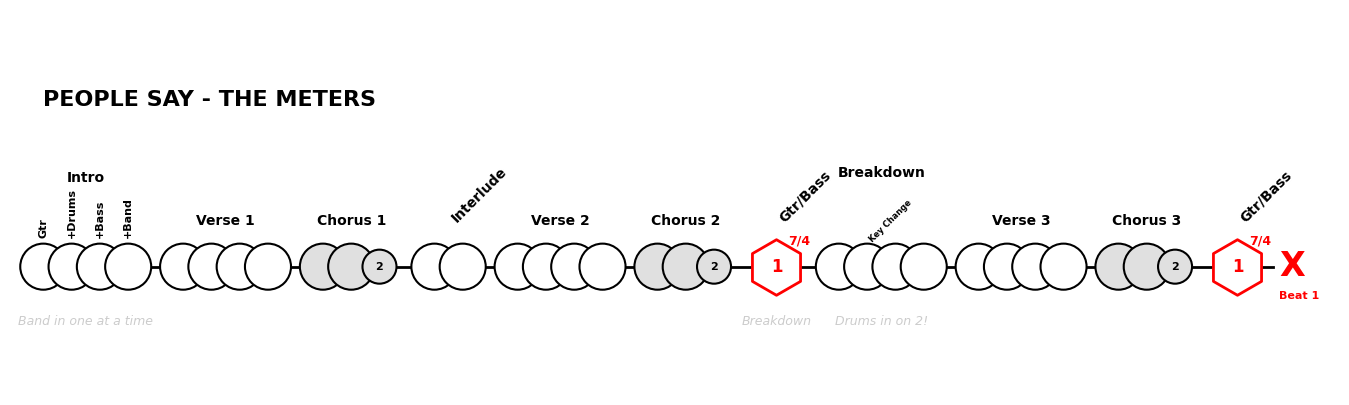

In [48]:
visualize_song("People Say - The Meters", people_say_data, style='non compact')

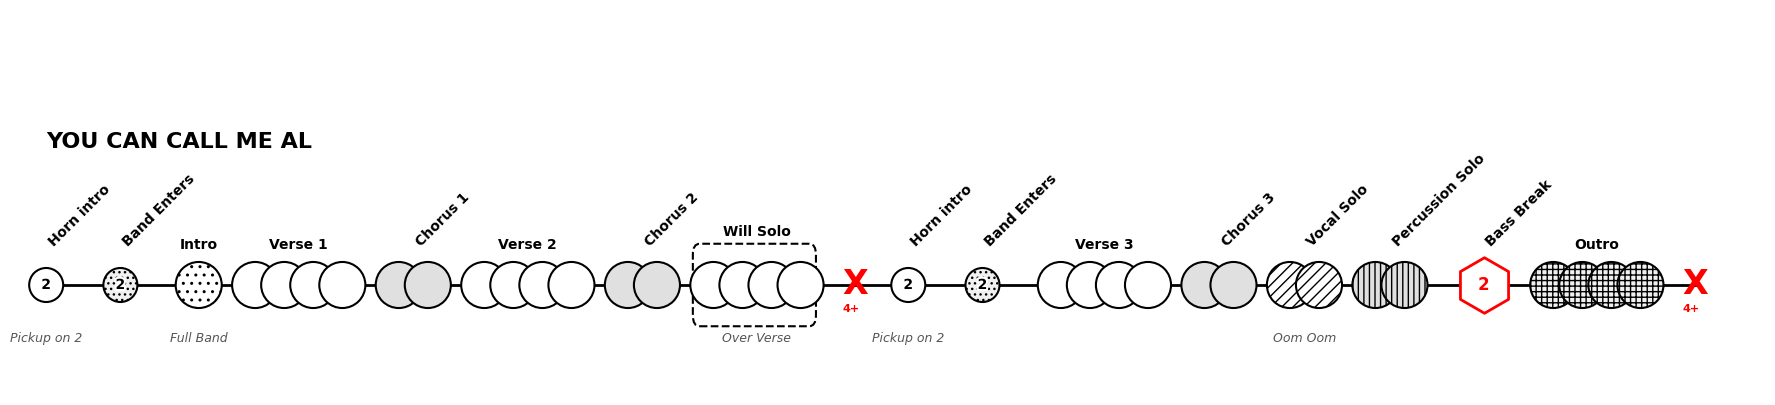

In [114]:
call_me_al_split = [
    {'name': 'Horn intro', 'bars': 2, 'force_beads': True, 'note':'Pickup on 2'},
    
    # 2. BAND HIT (2 Bars)
    {'name': 'Band Enters', 'bars': 2, 'force_beads': True},
    
    # 3. THE RIFF (4 Bars)
    # The standard 4-bar bead to finish the phrase.
    {'name': 'Intro', 'bars': 4, 'note': 'Full Band'},
    
    {'name': 'Verse 1', 'bars': 16},
    {'name': 'Chorus 1', 'bars': 8},
    {'name': 'Verse 2', 'bars': 16},
    {'name': 'Chorus 2', 'bars': 8},

    {'name': 'Verse 3', 'bars': 16, 'solo': 'Will Solo', 'ending': 'stop','ending_beat':'4+','note':"Over Verse"},
    
    {'name': 'Horn intro', 'bars': 2, 'force_beads': True, 'note':'Pickup on 2'},
    
    # 2. BAND HIT (2 Bars)
    {'name': 'Band Enters', 'bars': 2, 'force_beads': True},
    
    {'name': 'Verse 3', 'bars': 16},
    {'name': 'Chorus 3', 'bars': 8},
    {'name': 'Vocal Solo', 'bars': 8, 'note': 'Oom Oom'},
    {'name': 'Percussion Solo', 'bars': 8},
     {'name': 'Bass Break', 'bars': 2},
     {'name': 'Outro', 'bars': 16, 'ending':'stop','ending_beat':'4+'}
]

visualize_song("You Can Call Me Al", call_me_al_split, style='compact')